# Transmon eigenenergies
Gengyan Zhang, May 4th, 2017

This is a script to reproduce Fig. 2 in [Jens' transmon paper](http://link.aps.org/doi/10.1103/PhysRevA.76.042319).
## Charge basis
The Hamiltonian is $$H = \sum_{n=-N_{\max}}^{N_{\max}}{4E_C\left(n\left|n\right\rangle\left\langle n\right|-n_g\right)^2}-\sum_{n=-N_{\max}}^{N_{\max-1}}{\frac{E_J}{2}\left(\left|n\right\rangle\left\langle n+1\right|+\left|n+1\right\rangle\left\langle n\right|\right)}.$$

In [1]:
%matplotlib inline
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import string
import time

In [2]:
# Parameters
Ec = 1
level = 3
Nc = 50
Ej = np.array([1.0, 5.0, 10.0, 50.0])
ng = np.arange(-2, 2, 0.01)

# Operators
N = qt.charge(Nc)  # charge operator
Ic = qt.qeye(2*Nc+1)  # Identity operator
T = qt.tunneling(2*Nc+1)  # tunneling operator


def cpb_charge(ng, Ej):
    '''
    Function that calculates eigenvalues of transmon
    Hamiltonian in charge basis.
    Input: gate charge ng, Josephson energy Ej
    Output: lowest three eigenenergies
    '''
    H = 4*Ec*(N - ng*Ic)**2 + 0.5*Ej*T
    return H.eigenenergies(eigvals=level)

Calculating Ej/Ec = 1.0 ... done.
Calculating Ej/Ec = 5.0 ... done.
Calculating Ej/Ec = 10.0 ... done.
Calculating Ej/Ec = 50.0 ... done.
Elapsed time: 2.26 seconds


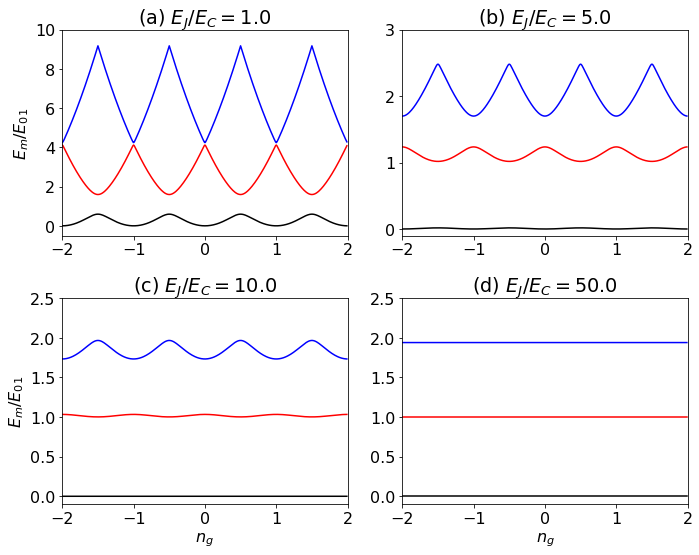

In [3]:
plt.rc('font', size=16)
plt.rc('axes', prop_cycle=(cycler(color='krb')))
ylims = [[-0.5, 10], [-0.1, 3], [-0.1, 2.5], [-0.1, 2.5]]
plt.figure(figsize=(10, 8))

tstart = time.time()
for ii in range(0, len(Ej)):
    print('Calculating Ej/Ec = {:.1f} ... '.format(Ej[ii]/Ec), end='')
    E = np.array(qt.parallel_map(cpb_charge, ng, task_args=(Ej[ii],)))
    E = E - np.min(E[:, 0])
    E = E/(np.min(E[:, 1] - E[:, 0]))
    plt.subplot(2, 2, ii+1)
    plt.plot(ng, E)
    plt.title('({}) $E_J/E_C={:.1f}$'.format(string.ascii_letters[ii], Ej[ii]))
    if ii > 1:
        plt.xlabel('$n_g$')
    if ii % 2 == 0:
        plt.ylabel('$E_m/E_{01}$')
    plt.xlim([-2, 2])
    plt.ylim(ylims[ii])
    print('done.')
print('Elapsed time: {:.2f} seconds'.format(time.time() - tstart))
plt.tight_layout()
plt.show()

## Phase basis
The Hamiltonian is
$$H = 4E_C\left(-i\frac{\partial}{\partial\varphi}-n_g\right)^2-E_J\cos\varphi.$$
The first and second order differentiations are approximated by
$$\frac{\partial}{\partial\varphi}\Psi(\varphi_n)\approx\frac{\Psi(\varphi_{n+1})-\Psi(\varphi_{n-1})}{2\Delta\varphi},\quad\frac{\partial^2}{\partial\varphi^2}\Psi(\varphi_n)\approx\frac{\Psi(\varphi_{n+1})-2\Psi(\varphi_n)+\Psi(\varphi_{n-1})}{\Delta\varphi^2}.$$

Since $\varphi\in[0, 2\pi)$ is compact, **periodic boundary condition** needs to be used, $\Psi(\varphi_N) = \Psi(\varphi_1)$.

The advantage of using phase basis is the method can be used for devices with extended $\varphi$, e.g., fluxonium.

In [4]:
# Use sparse matrix methods from scipy
from scipy.sparse import diags, eye

Np = 200

# Discetize phi, remove last point due to periodic boundary condition
phi = np.linspace(-np.pi, np.pi, Np+1)[:-1]
dphi = (phi[-1] - phi[0])/(Np - 1)

# Finite difference matrix for d/d(phi)
diff1 = diags([np.ones(Np-1), -np.ones(Np-1)], [1, -1])
# Add matrix for periodic boundary condition
diff1 += diags([1, -1],  [-Np+1, Np-1])
diff1 = diff1/(2*dphi)

# Finite difference matrix for d^2/d(phi)^2
diff2 = diags([-2*np.ones(Np), np.ones(Np-1), np.ones(Np-1)], [0, 1, -1])
# Add matrix for periodic boundary condition
diff2 += diags([1, 1], [-Np+1, Np-1])
diff2 = diff2/dphi**2

# Identity matrix
Id = eye(Np)
# Matrix for cos(phi)
CPhi = diags(np.cos(phi))

def cpb_phase(ng, Ej):
    '''
    Function that calculates eigenvalues of transmon
    Hamiltonian in phase basis.
    Input: gate charge ng, Josephson energy Ej
    Output: lowest three eigenenergies
    '''
    H = qt.Qobj(4*Ec*(-diff2 - 2*(-1j)*diff1*ng + ng**2*Id) - Ej*CPhi)
    return H.eigenenergies(sparse=True, eigvals=level)

## Remarks
In the above code, the Hamiltonian is constructed using `scipy.sparse` methods and then passed to `qutip.Qobj`. This is not necessary because QuTiP will automatically convert data to sparse form, and constructing $H$ using `numpy` will give the same result.

When using `eigenenergies()` or `eigenstates()` methods in QuTiP, by default **non-sparse** method will be used, which is fast but takes more memory. If the `sparse` keyword is set to `True` to enable sparse method, calculation will be much slower but consumes less memory. This is useful when you have a very large Hilbert space.

Calculating Ej/Ec = 1.0 ... done.
Calculating Ej/Ec = 5.0 ... done.
Calculating Ej/Ec = 10.0 ... done.
Calculating Ej/Ec = 50.0 ... done.
Elapsed time: 148.04 seconds


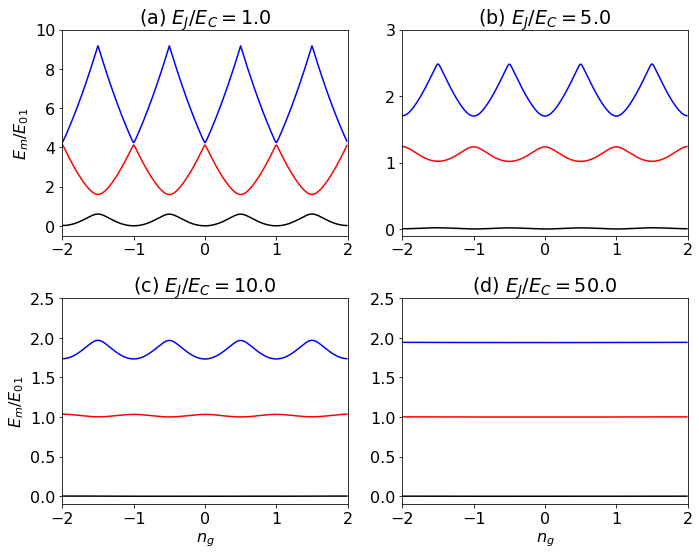

In [5]:
plt.figure(figsize=(10, 8))

tstart = time.time()
for ii in range(0, len(Ej)):
    print('Calculating Ej/Ec = {:.1f} ... '.format(Ej[ii]/Ec), end='')
    E = np.array(qt.parallel_map(cpb_phase, ng, task_args=(Ej[ii],)))
    E = E - np.min(E[:, 0])
    E = E/(np.min(E[:, 1] - E[:, 0]))
    plt.subplot(2, 2, ii+1)
    plt.plot(ng, E)
    plt.title('({}) $E_J/E_C={:.1f}$'.format(string.ascii_letters[ii], Ej[ii]))
    if ii > 1:
        plt.xlabel('$n_g$')
    if ii % 2 == 0:
        plt.ylabel('$E_m/E_{01}$')
    plt.xlim([-2, 2])
    plt.ylim(ylims[ii])
    print('done.')
print('Elapsed time: {:.2f} seconds'.format(time.time() - tstart))
plt.tight_layout()
plt.show()

The following is an interactive plot for charge dispersion vs $E_J/E_C$ (Only works when running locally).

In [6]:
from ipywidgets import interact, FloatSlider

def plotE(Ej):
    plt.figure()
    E = np.array(qt.parallel_map(cpb_charge, ng, task_args=(Ej,)))
    E = E - np.min(E[:, 0])
    E = E/(np.min(E[:, 1] - E[:, 0]))
    plt.plot(ng, E)
    plt.title('$E_J/E_C={:.1f}$'.format(Ej))
    plt.xlabel('$n_g$')
    plt.ylabel('$E_m/E_{01}$')
    plt.show()
              
interact(plotE, Ej=FloatSlider(min=1, max=100, step=1, continuous_update=False))

A Jupyter Widget

<function __main__.plotE>

In [7]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.1.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.26
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
